### Import library

In [1]:
!sudo pip3.10 install torch torchvision torchinfo matplotlib scikit-learn pandas numpy==1.23

In [2]:
# Import the necessary libraries
import torch
import torchvision
from torchvision import datasets,transforms,models
import torch.nn as nn
import torch.nn.functional as F
from torch import nn,optim,no_grad
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from torchinfo import summary

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import pickle
import sys
import time

In [3]:
has_mps = torch.backends.mps.is_built()
device = "cuda" if torch.cuda.is_available() else "mps" if has_mps else "cpu"
print(f"Python versoin: {sys.version_info.major, sys.version_info.minor, sys.version_info.micro}")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

Python versoin: (3, 10, 17)
PyTorch version: 2.6.0+cu124
Device: cuda


###Dataset and setting


In [4]:
import os

In [5]:
! cd COMP7055Project/train/angry
! cd .ipynb_checkpoints
! ls COMP7055Project/train/.ipynb_checkpoints
! rmdir COMP7055Project/train/.ipynb_checkpoints



ls: cannot access 'COMP7055Project/train/.ipynb_checkpoints': No such file or directory
rmdir: failed to remove 'COMP7055Project/train/.ipynb_checkpoints': No such file or directory


In [6]:
# Define data transformations for the training and test sets
train_transform = transforms.Compose([
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomCrop(32, padding=4),
    #  transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1)),
     transforms.ToTensor(), # Convert images to tensors
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))]) # Normalize the image data

test_transform = transforms.Compose([
     transforms.ToTensor(), # Convert images to tensors
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))]) # Normalize the image data

# Create the CIFAR10dataset for the training set with 50,000 images
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)

# Create the CIFAR10 dataset for the test set with 10,000 images (It is also used as validation set during the training)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# Define the data loaders for the training, validation, and test sets
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False, num_workers=2)

# Define the classes for the CIFAR-10 dataset
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


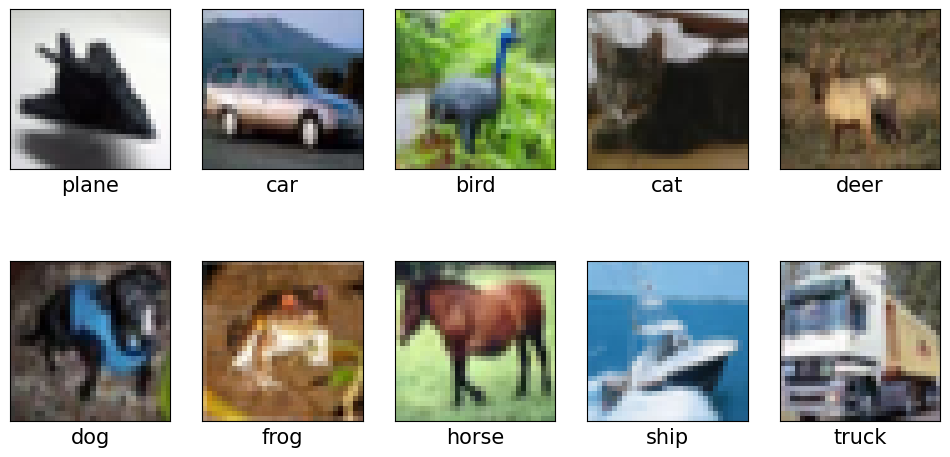

In [7]:
# Visualize training image for each class
sample_images = [train_set.data[np.asarray(train_set.targets) == label][0] for label in range(10)]
# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(classes[i], fontsize=15)
    axis.imshow(sample_images[i])
    i += 1

In [8]:
#define VGG version
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [9]:
#define VGG model
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.features = self._make_layers()
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self):
        layers = []
        in_channels = 3
        print(cfg['VGG19'])
        for x in cfg['VGG19']:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


def test():
    net = VGG()
    x = torch.randn(2,3,32,32)
    y = net(x)
    print(y.size())


In [43]:
model = VGG()

[64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']


In [44]:
summary(model=model, input_size=(1, 3, 32, 32), col_width=15,
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape     Output Shape    Param #         Trainable
VGG (VGG)                                [1, 3, 32, 32]  [1, 10]         --              True
├─Sequential (features)                  [1, 3, 32, 32]  [1, 512, 1, 1]  --              True
│    └─Conv2d (0)                        [1, 3, 32, 32]  [1, 64, 32, 32] 1,792           True
│    └─BatchNorm2d (1)                   [1, 64, 32, 32] [1, 64, 32, 32] 128             True
│    └─ReLU (2)                          [1, 64, 32, 32] [1, 64, 32, 32] --              --
│    └─Conv2d (3)                        [1, 64, 32, 32] [1, 64, 32, 32] 36,928          True
│    └─BatchNorm2d (4)                   [1, 64, 32, 32] [1, 64, 32, 32] 128             True
│    └─ReLU (5)                          [1, 64, 32, 32] [1, 64, 32, 32] --              --
│    └─MaxPool2d (6)                     [1, 64, 32, 32] [1, 64, 16, 16] --              --
│    └─Conv2d (7)                        [1, 64, 16, 16] [1, 

In [45]:
!mkdir Models_VGG4.0

mkdir: cannot create directory ‘Models_VGG4.0’: File exists


In [46]:
# Specify Loss/Cost function
criterion = nn.CrossEntropyLoss()

# loss and optimization functions
lr=0.001
momentum = 0.9

# optimizer selection (SGD, Adam, RMSprop, NAdam)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, momentum=momentum)
#optimizer = torch.optim.NAdam(model.parameters(), lr=lr)


In [47]:
EPOCHS = 50

loss_hist, acc_hist = [], []  # Lists to store training loss and accuracy
loss_hist_test, acc_hist_test = [], []  # Lists to store validation loss and accuracy

model.to(device)  # Move the model to the specified device (e.g., GPU)

print("Training was started.\n")

for epoch in range(1, EPOCHS + 1):
    time_ckpt = time.time()
    print("EPOCH:", epoch, end=" ")
    running_loss = 0.0
    correct = 0

    # Training loop
    for data in train_loader:
        batch, labels = data

        batch, labels = batch.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear the gradients
        outputs = model(batch)  # Forward pass  
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass (compute gradients)
        optimizer.step()  # Update the model's parameters

        # Compute training statistics
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_set)  # Average training loss for the epoch
    avg_acc = correct / len(train_set)  # Average training accuracy for the epoch
    loss_hist.append(avg_loss)
    acc_hist.append(avg_acc)

    # Validation statistics
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        loss_test = 0.0
        correct_test = 0

        # Validation loop
        for data in test_loader:
            batch, labels = data
            batch, labels = batch.to(device), labels.to(device)
            outputs = model(batch)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            loss_test += loss.item()

        avg_loss_test = loss_test / len(test_set)  # Average validation loss for the epoch
        avg_acc_test = correct_test / len(test_set)  # Average validation accuracy for the epoch
        loss_hist_test.append(avg_loss_test)
        acc_hist_test.append(avg_acc_test)

    model.train()  # Set the model back to training mode
#     scheduler.step(avg_loss_val) # Check the scheduler for updating the learning rate

    # Save the model at the end of each epoch
    if avg_acc_test >= max(acc_hist_test) and epoch > 30:
        with open("Models_VGG4.0/Image_Classification_{}.pth".format(epoch), "wb") as f:
            model.eval()
            pickle.dump(model, f)
            model.train()

    print("Train Loss: {:.3f}".format(avg_loss * 100), end=" ")
    print("Test Loss: {:.3f}".format(avg_loss_test * 100), end=" ")
    print("Train Accuracy: {:.2f}%".format(avg_acc * 100), end=" ")
    print("Test Accuracy: {:.2f}%".format(avg_acc_test * 100), end=" ")
    print("Time: {:.2f}s".format(time.time() - time_ckpt), end=" \n")


Training was started.

EPOCH: 1 Train Loss: 5.883 Test Loss: 0.640 Train Accuracy: 25.96% Test Accuracy: 35.70% Time: 23.93s 
EPOCH: 2 Train Loss: 4.227 Test Loss: 0.463 Train Accuracy: 48.90% Test Accuracy: 58.66% Time: 24.06s 
EPOCH: 3 Train Loss: 3.294 Test Loss: 0.362 Train Accuracy: 62.71% Test Accuracy: 67.46% Time: 23.94s 
EPOCH: 4 Train Loss: 2.818 Test Loss: 0.306 Train Accuracy: 68.79% Test Accuracy: 73.90% Time: 24.21s 
EPOCH: 5 Train Loss: 2.442 Test Loss: 0.286 Train Accuracy: 73.95% Test Accuracy: 76.01% Time: 23.98s 
EPOCH: 6 Train Loss: 2.178 Test Loss: 0.283 Train Accuracy: 77.07% Test Accuracy: 77.58% Time: 24.01s 
EPOCH: 7 Train Loss: 1.933 Test Loss: 0.229 Train Accuracy: 79.94% Test Accuracy: 81.38% Time: 24.01s 
EPOCH: 8 Train Loss: 1.766 Test Loss: 0.232 Train Accuracy: 81.85% Test Accuracy: 82.08% Time: 24.01s 
EPOCH: 9 Train Loss: 1.595 Test Loss: 0.201 Train Accuracy: 83.77% Test Accuracy: 84.36% Time: 24.05s 
EPOCH: 10 Train Loss: 1.467 Test Loss: 0.197 Train

### Test the Trained Network

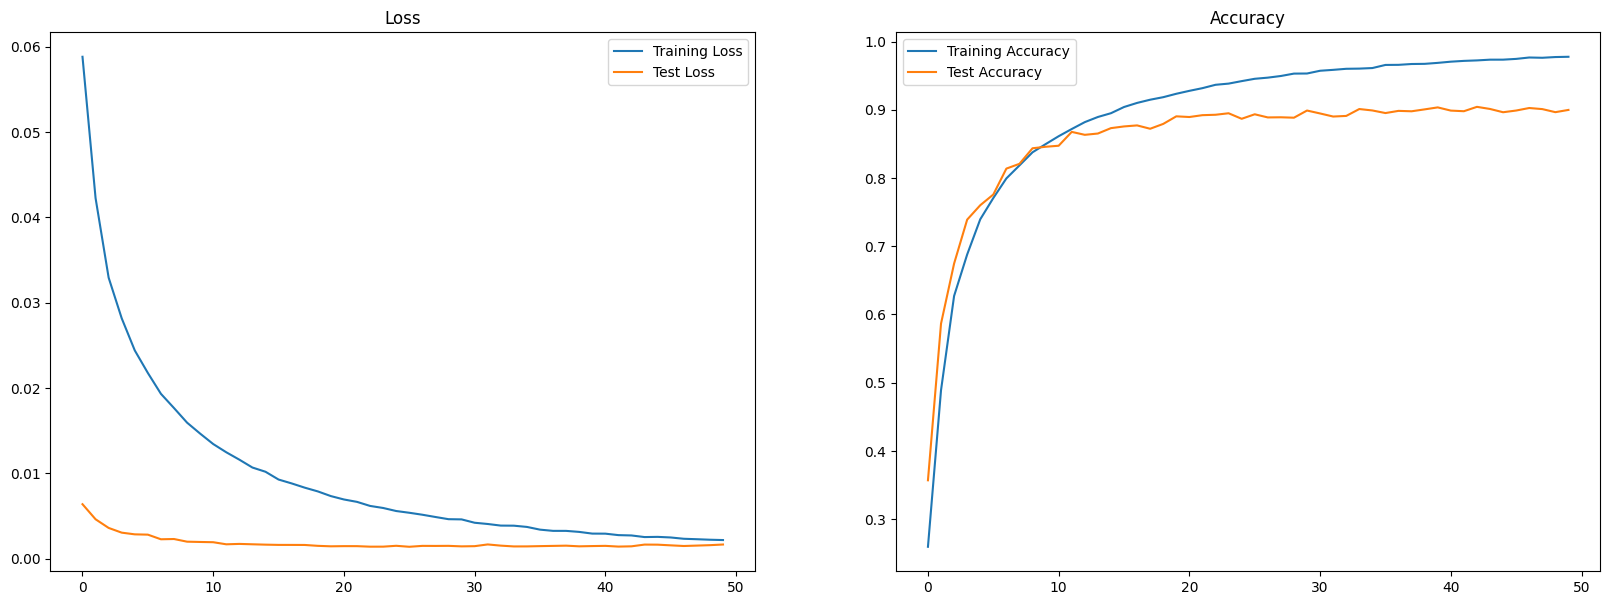

In [48]:
plots=[(loss_hist,loss_hist_test),(acc_hist,acc_hist_test)]
plt_labels=[("Training Loss","Test Loss"),("Training Accuracy","Test Accuracy")]
plt_titles=["Loss","Accuracy"]
plt.figure(figsize=(20,7))
for i in range(0,2):
    ax=plt.subplot(1,2,i+1)
    ax.plot(plots[i][0],label=plt_labels[i][0])
    ax.plot(plots[i][1],label=plt_labels[i][1])
    ax.set_title(plt_titles[i])
    ax.legend()

### Recalculate Test Set Accuracy

In [49]:
# Selecting the best model
best_acc = max(acc_hist_test)
best_epoch = acc_hist_test.index(best_acc)+1

print("Best accuracy on test set: {:.2f}%".format(best_acc*100))
print("Best epoch: {}".format(best_epoch))

# Load the best model
with open(f"Models_VGG4.0/Image_Classification_{best_epoch}.pth","rb") as f:
    loaded_model=pickle.load(f)

Best accuracy on test set: 90.43%
Best epoch: 43


### Display the Test Set Accuracy

In [50]:
pred_vec = []
label_vec = []
correct = 0
test_loss = 0.0
avg_test_loss = 0.0
model = loaded_model
model.to(device)

with torch.no_grad():
    for data in test_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = model(batch)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        test_loss += loss.item()
        pred_vec.extend(predicted.cpu().numpy())  # Convert tensor to numpy array
        label_vec.extend(labels.cpu().numpy())  # Convert tensor to numpy array

    avg_test_loss = test_loss / len(test_set)

pred_vec = np.array(pred_vec)
label_vec = np.array(label_vec)


In [51]:
print(F"Test Loss: {avg_test_loss}")
print(F"Test Accuracy on the {len(test_set)} test images: {(100 * correct / len(test_set))}%")

Test Loss: 0.0014614913046360016
Test Accuracy on the 10000 test images: 90.43%


### Display the Confusion Matrix

In [52]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(label_vec, pred_vec)
# Convert confusion matrix to pandas DataFrame
labels = np.unique(label_vec)
print(labels)
confusion_df = pd.DataFrame(confusion_mat, index=classes, columns=classes)
print("Confusion Matrix")
confusion_df

[0 1 2 3 4 5 6 7 8 9]
Confusion Matrix


,plane,car,bird,cat,deer,dog,frog,horse,ship,truck
plane,937,4,17,15,6,1,0,3,8,9
car,5,954,0,5,1,1,1,0,4,29
bird,19,0,887,22,28,16,19,7,2,0
cat,10,2,26,829,22,72,13,17,2,7
deer,4,0,23,26,911,6,15,15,0,0
dog,1,0,14,105,18,830,2,27,0,3
frog,5,0,24,29,10,2,926,2,1,1
horse,9,0,4,17,24,10,0,933,0,3
ship,57,12,8,4,0,0,3,0,901,15
truck,17,26,0,8,0,1,0,2,11,935


### Compute theyje Accuracy, F1-score,OPrecision,Recall,Support

In [53]:
# Create a report to show the f1-score, precision, recall
from sklearn.metrics import classification_report

report = pd.DataFrame.from_dict(classification_report(pred_vec,label_vec,output_dict=True)).T
report['Label']=[classes[int(x)] if x.isdigit() else " " for x in report.index]
report=report[['Label','f1-score','precision','recall','support']]
report

,Label,f1-score,precision,recall,support
0,plane,0.907946,0.93700,0.880639,1064.0000
1,car,0.954955,0.95400,0.955912,998.0000
2,bird,0.885671,0.88700,0.884347,1003.0000
3,cat,0.804854,0.82900,0.782075,1060.0000
4,deer,0.901980,0.91100,0.893137,1020.0000
5,dog,0.856111,0.83000,0.883919,939.0000
6,frog,0.935826,0.92600,0.945863,979.0000
7,horse,0.930209,0.93300,0.927435,1006.0000
8,ship,0.934163,0.90100,0.969860,929.0000
9,truck,0.934066,0.93500,0.933134,1002.0000
